# Exercise 7.1

If buses arrive at a bus stop every 20 minutes, and you arrive at the bus stop at a random time, your wait time until the bus arrives is uniformly distributed from 0 to 20 minutes.

But in reality, there is variability in the time between buses. Suppose you are waiting for a bus, and you know the historical distribution of time between buses. Compute your distribution of wait times.

*Hint*: Suppose that the time between buses is either 5 or 10 minutes with equal probability. What is the probability that you arrive during one of the 10 minute intervals?

### Theory

$P(wait)=\sum{P(wait|interval_i)P(interval_i)}$

This is what is refered to as a mixture of distribution. Every distribution has a probability of happening. Then you can compute the probability of every wait time.

This is different than the example given in chapter 8 where they calculate the average time between buses. It's either 5 or 10 minutes each with probability 50%. That gives an average time between buses of $5*0.5 + 10*0.5=7.5$. Here we want to calculate our own wait time.

### Practice

In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), 'code'))

In [32]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [31]:
from thinkbayes2 import MakeUniformPmf, MakeMixture, Pmf
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
u5 = MakeUniformPmf(0,5,6)
u10 = MakeUniformPmf(0,10,11)

In [22]:
metapmf = Pmf()
metapmf.Set(u5, 1)
metapmf.Set(u10, 1)
metapmf.Normalize()
mix = MakeMixture(metapmf)

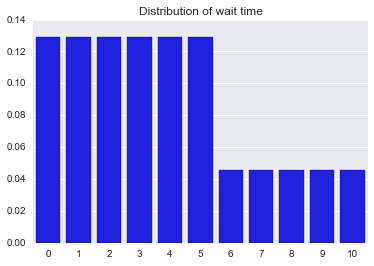

In [48]:
g = sns.barplot(x=list(range(11)), y=[mix.Prob(i) for i in range(11)], color='b')
g = g.set_title("Distribution of wait time")

In [53]:
print("On average the wait time is {} minutes for that distribution".format(mix.Mean()))

On average the wait time is 3.75 minutes for that distribution


But if you were to arrive at the bus stop, what would be the perceived average wait time? You are more likely to arrive during a 10 minutes period.

In [54]:
metapmf = Pmf()
metapmf.Set(u5, 5)
metapmf.Set(u10, 10)
metapmf.Normalize()
mix = MakeMixture(metapmf)

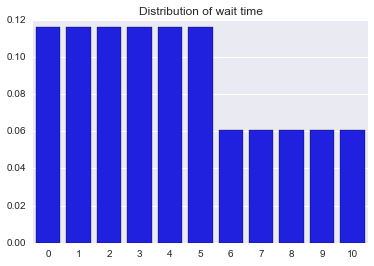

In [55]:
g = sns.barplot(x=list(range(11)), y=[mix.Prob(i) for i in range(11)], color='b')
g = g.set_title("Distribution of wait time")

In [57]:
print("On average you will wait {:.2f} minutes for that distribution at the bus station".format(mix.Mean()))

On average you will wait 4.17 minutes for that distribution at the bus station


# Exercise 7.2

Suppose that passengers arriving at the bus stop are well-modeled by a Poisson process with parameter λ. If you arrive at the stop and find 3 people waiting, what is your posterior distribution for the time since the last bus arrived.

### Theory

- $t$ represents the time since last bus
- $T$ is the time between two buses
- $k$ represents the number of person already waiting
- We are looking for $P(t|k=3)$
- $\lambda$ is the number of person arriving at the bus stop every minutes

$P(t|k=3)=\frac{P(k=3|t)P(t)}{P(k=3)}=\frac{P(k=3|t)}{T \cdot P(k=3)}$

- $P(k=3|t) \sim Poisson(t\lambda)$ 
- $P(t) \sim Uniform(T)$ with the discrete version of a uniform
- $P(k=3)=\sum_{i=1}^T{P(k=3|t=i)P(t=i)}=\frac{1}{T}\sum_{i=1}^T{P(k=3|t=i)}$

### Practice

In [163]:
from thinkbayes2 import EvalPoissonPmf, Suite, MakePoissonPmf

In [81]:
class TimeSince(Suite):
    def __init__(self, values, lam):
        super(TimeSince, self).__init__(values)
        self.lam = lam
        
    def Likelihood(self, data, hypo):
        t = hypo
        k = data
        like = EvalPoissonPmf(self.lam*t, k)
        return like

In [126]:
xs = np.linspace(0,20,100) # use 100 time points just to get a smoother curve below
ts = TimeSince(xs, 1) # suppose lambda = 1, i.e. passenger arrive at the rate of 1 per minute
ts.Update(3)

0.048850989888619953

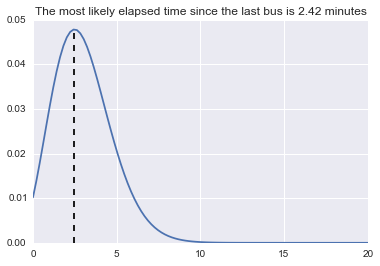

In [127]:
y = np.array([ts.Prob(t) for t in xs])
plt.plot(xs, y)
plt.vlines(xs[np.argmax(y)], y.min(), y.max(), linestyles='--')
_=plt.title("The most likely elapsed time since the last bus is {:.2f} minutes".format(xs[np.argmax(y)]))

# Exercise 7.3 

Suppose that you are an ecologist sampling the insect population in a new environment. You deploy 100 traps in a test area and come back the next day to check on them. You find that 37 traps have been triggered, trapping an insect inside. Once a trap triggers, it cannot trap another insect until it has been reset.

If you reset the traps and come back in two days, how many traps do you expect to find triggered? Compute a posterior predictive distribution for the number of traps.

### Theory

This is a problem that can be solved with a Poisson distribution. Thing is, we don't know the average trap rate. We only know that after one day we got 37.

We have to make a few simplifications otherwise the problem becomes way more complicated. Taken from the Wikipedia page for [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution#Assumptions:_When_is_the_Poisson_distribution_an_appropriate_model.3F):
- The rate at which events occur is constant. The rate cannot be higher in some intervals and lower in other intervals.
- Two events cannot occur at exactly the same instant.

Both are false. As we trap insects, we have less and less active traps. So the rate is getting lower as time goes by. Also, two traps can be set off at the same time. So for now, if not forever, we will assume that the trap rate is constant over time and that two traps cannot be set off at the same time.

- $k$ is the number of insects traped after 2 days
- $37$ will be the information that we got 37 after 1 day
- $\lambda$ is the trap rate for 1 day

$P(k|37)=\frac{P(k,37)}{P(37)}=\frac{\sum_{\Lambda}{P(k,37,\lambda)}}{P(37)}=\frac{\sum_{\Lambda}{P(k|37,\lambda)P(\lambda|37)P(37)}}{P(37)}=\sum_{\Lambda}{P(k|\lambda)P(\lambda|37)}$

$P(\lambda|37)$ is the distribution of possible trap rate. That is our posterior knowledge about $\lambda$, which is a lot better than assuming a uniform distribution.

So essentially we have a mixture of distribution for $k$ based on the distribution of $\lambda$

### Practice

Again this is a Poisson distribution. We don't know the rate of traps triggered, but we can get a posterior distribution based on the fact that we got 37 in one day. $P(\lambda|37)$

In [207]:
class Trap(Suite):
    def __init__(self, values):
        super(Trap, self).__init__(values)
        
    def Likelihood(self, data, hypo):
        lam = hypo
        k = data
        like = EvalPoissonPmf(k, lam)
        return like

In [208]:
lambdas = range(1,76) # Suppose we can trap up to 75 per day

In [210]:
trap = Trap(lambdas)
trap.Update(37)
print("Mean: {:.2f}, Std: {:.2f}".format(trap.Mean(), trap.Std()))

Mean: 38.00, Std: 6.16


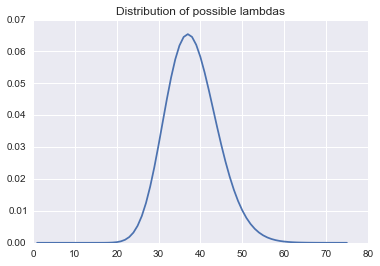

In [199]:
y = np.array([trap.Prob(lam) for lam in lambdas])
plt.plot(lambdas, y)
_=plt.title("Distribution of possible lambdas")

And here comes the mixture

In [201]:
def PosteriorK(suite, high=100):     
    metapmf = Pmf()
    for lam, prob in suite.Items():
        poisson = MakePoissonPmf(2*lam, high)
        metapmf.Set(poisson, prob)
    return MakeMixture(metapmf)

In [202]:
post = PosteriorK(trap, 100)

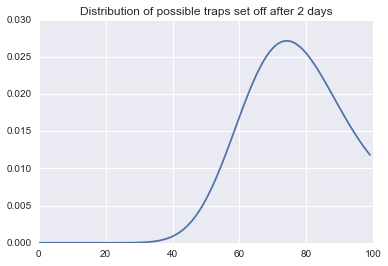

In [203]:
K = np.arange(0,100)
y = np.array([post.Prob(k) for k in K])
plt.plot(K, y)
_=plt.title("Distribution of possible traps set off after 2 days")

In [211]:
print("Mean: {:.2f}, Std: {:.2f}".format(post.Mean(), post.Std()))

Mean: 74.91, Std: 13.28


# Exercise 7.4

Suppose you are the manager of an apartment building with 100 light bulbs in common areas. It is your responsibility to replace light bulbs when they break.

On January 1, all 100 bulbs are working. When you inspect them on February 1, you find 3 light bulbs out. If you come back on April 1, how many light bulbs do you expect to find broken?

In the previous exercise, you could reasonably assume that an event is equally likely at any time. For light bulbs, the likelihood of failure depends on the age of the bulb. Specifically, old bulbs have an increasing failure rate due to evaporation of the filament.

This problem is more open-ended than some; you will have to make modeling decisions. You might want to read about the Weibull distribution (http://en.wikipedia.org/wiki/Weibull_distribution). Or you might want to look around for information about light bulb survival curves.

### Theory

Before we dig into this problem, I will generalize the idea above with unspecified distribution parameters with $\theta \in \Theta$ and observed data.

$P(T|data)=\frac{P(T,data)}{P(data)}=\frac{\sum_{\Theta}{P(T,data,\theta)}}{P(data)}=\frac{\sum_{\Theta}{P(T|data,\theta)P(\theta|data)P(data)}}{P(data)}=\sum_{\Theta}{P(T|\theta)P(\theta|data)}$

And

$P(\theta|data)=\frac{P(data|\theta)P(\theta)}{P(data)}=\frac{P(data|\theta)P(\theta)}{\sum_{\theta \in \Theta}{P(data| \theta)P(\theta)}}$

The problem is similar to 7.3 except that we cannot use a Poisson distribution for when lights go out. We are steared towards the Weibull distribution. That distribution can be used to represent an aging process. $\lambda$ and $k$ parametrarize this function.

$$\frac{k}{\lambda}\left(\frac{x}{\lambda}\right)^{k-1}e^{-(x/\lambda)^k}$$

If the quantity X is a "time-to-failure", the Weibull distribution gives a distribution for which the failure rate is proportional to a power of time. The shape parameter, k, is that power plus one, and so this parameter can be interpreted directly as follows:

A value of k > 1 indicates that the failure rate increases with time. This happens if there is an "aging" process, or parts that are more likely to fail as time goes on.

Similar notation to the previous problem as well.

- $x$ is the number of lights that will go out after another 2 month
- $3$ will be the information that there were 3 lights out after the first month
- $\lambda$ and $k$ are the parameter for the Weibull

$P(x|3)=\frac{P(x,3)}{P(3)}=\frac{\sum_{\Theta}{P(x,3,\theta)}}{P(3)}=\frac{\sum_{\Theta}{P(x|3,\theta)P(\theta|3)P(3)}}{P(3)}=\sum_{\Theta}{P(x|\theta)P(\theta|3)}$

where $\theta$ is the vector containing $\lambda$ and $k$

$P(x|3)=\sum_{\Lambda,K}{P(x|\lambda, k)P(\lambda,k|3)}$

and

$P(\lambda,k|3)=\frac{P(3|\lambda,k)P(\lambda,k)}{\sum_{\Lambda,K}{P(3|\lambda, k)P(\lambda,k)}}$

In [207]:
class Light(Suite):
    def __init__(self, values):
        super(Trap, self).__init__(values)
        
    def Likelihood(self, data, hypo):
        lam = hypo
        k = data
        like = EvalPoissonPmf(k, lam)
        return like

In [208]:
lambdas = range(1,76) # Suppose we can trap up to 75 per day

In [210]:
trap = Trap(lambdas)
trap.Update(37)
print("Mean: {:.2f}, Std: {:.2f}".format(trap.Mean(), trap.Std()))

Mean: 38.00, Std: 6.16


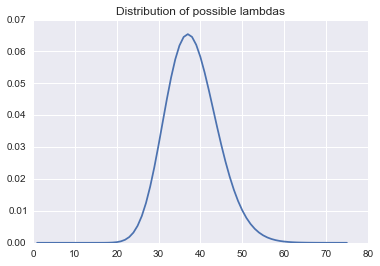

In [199]:
y = np.array([trap.Prob(lam) for lam in lambdas])
plt.plot(lambdas, y)
_=plt.title("Distribution of possible lambdas")

In [ ]:
V